In [34]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from math import sqrt, floor, ceil
from PIL import Image
import math
import cmath
from scipy import ndimage
import scipy.misc
import scipy.ndimage.filters
import matplotlib.cm as cm
from itertools import product
import tkinter as tk
from tkinter import *
from tkinter import filedialog
from tkinter.filedialog import askopenfile
from PIL import Image, ImageTk
from io import BytesIO

In [35]:
def Padding(photo,width,height,channel,size):
    photo_copy =np.zeros((width+2*size,height+2*size,channel), dtype=np.float)
    photo_copy[size:size+width,size:size+height] = photo.copy().astype(np.float)
    
    return photo_copy

# Spatial Domain Filters:

## 1- Median Filter:

In [36]:
def MedianFilter(photo):
    ##filter size is hardcoded
    width,height,c= photo.shape ##c is for number of channels
    size = 15//2
    
    ##GENERATE PADDING##
    photo_copy = Padding(photo,width,height,c,size)
    RES= photo_copy.copy()
    ###################
    
    ##PERFORM FILTERING BY LOOPING ON BOTH WIDTH AND HEIGHT AND C###
    for x in range(width):
        for y in range(height):
            for z in range(c):
                RES[x+size,y+size,z] = np.median(photo[x:x+15,y:y+15,z])  ##by using the median function to get each pixel
    RES = RES[size:size+width,size:size+height].astype(np.uint8)
    return RES

## 2- Averaging Filter

In [37]:
def AverageFilter(photo,FilterSize):
    width,height,c= photo.shape ##c is for number of channels
    size = FilterSize//2
    RES= photo.copy()
    for x in range(size, width, FilterSize):
        for y in range(size, height, FilterSize):
            RES[x-size:x+size,y-size:y+size,0] = np.mean(img[x-size:x+size,y-size:y+size,0])
            RES[x-size:x+size,y-size:y+size,1] = np.mean(img[x-size:x+size,y-size:y+size,1])
            RES[x-size:x+size,y-size:y+size,2] = np.mean(img[x-size:x+size,y-size:y+size,2])
#     cv2.imwrite('Averaging.jpg', RES)
    return RES

In [58]:
# img = cv2.imread("Gray_Scale.jpg")
# img = AverageFilter(img,7)
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.show()

## 3- Gaussian Filter

In [38]:
def GaussianFilter(photo,FilterSize,StandDev):
    width,height,c= photo.shape ##c is for number of channels
    size = FilterSize//2
    
    photo_copy =  Padding(photo,width,height,c,size)
    RES= photo_copy.copy()
    ###################
    
    ##1.Create Kernel
    kernel = np.zeros((FilterSize,FilterSize), dtype=np.float)
    for x in range(-1*size,FilterSize-size):
        for y in range(-1*size,FilterSize-size):
              kernel[x+size,y+size] = (1/(2*np.pi*(StandDev**2)))*np.exp(-1*(x**2+y**2)/(2*(StandDev**2)))
    kernel /= kernel.sum()
    ##2.Filtering
    for x in range(width):
        for y in range(height):
            for z in range(c):
                RES[x+size,y+size,z] = np.sum(kernel*photo_copy[x:x+FilterSize,y:y+FilterSize,z])
    RES = RES[size:size+width,size:size+height].astype(np.uint8)
    return RES

## 4- Laplacian Operator

In [39]:
def show_abs(I, plot_title):    
    plt.title(plot_title)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(abs(I), cm.gray)

In [40]:
#Reading the image into numpy array:
def Laplacian():
    pic_n = 1
    A = cv2.imread("Gray_Scale.jpg",0).astype('float64')

    plt.figure(pic_n)
    pic_n += 1
    show_abs(A, 'Original image')

    A -= np.amin(A) #map values to the (0, 255) range
    A *= 255.0/np.amax(A)

    #Kernel for negative Laplacian
    kernel = np.ones((3,3))*(-1)
    kernel[1,1] = 8

    #Convolution of the image with the kernel:
    Lap = convolve2d(A,kernel)

    #Laplacian now has negative values in range (-255, 255):
    #print('L', np.amax(Lap), np.amin(Lap))

    plt.figure(pic_n)
    pic_n += 1
    show_abs(Lap, 'Laplacian')

    A += Lap #Add negative Laplacian to the original image

    #print('A', np.amax(A), np.amin(A))
    A -= np.amin(A)
    A *= 255.0/np.amax(A)
    #print('A', np.amax(A), np.amin(A))

    plt.figure(pic_n)
    pic_n += 1
    show_abs(A, 'Laplacian filtered img')
    return A

# plt.show()

## 5- Unsharp Masking

In [41]:
def unsharp_mask(image, kernel_size, sigma, amount, threshold):
    image = cv2.imread("Unsharp_Image.jpg")
    
    sharpened = float(amount + 1) * image - float(amount) 
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

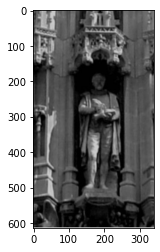

In [42]:
img = cv2.imread("Unsharp_Image.jpg")

sharp = unsharp_mask(img , (5,5) ,1.0,-0.2,0)
# plt.imshow(sharp)

plt.imshow(cv2.cvtColor(sharp, cv2.COLOR_BGR2RGB))
plt.show()

## 6- Roberts Cross-Gradient Operators

In [43]:
def RobertConvolve(image, kernel):
    # Flip the kernel
    kernel = np.flipud(np.fliplr(kernel))
    # convolution output
    output = np.zeros_like(image)

    # Add zero padding to the input image
    image_padded = np.zeros((image.shape[0] + 2, image.shape[1] + 2))
    image_padded[1:-1, 1:-1] = image

    # Loop over every pixel of the image
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            # element-wise multiplication of the kernel and the image
            output[y, x]=(kernel * image_padded[y: y+2, x: x+2]).sum()

    return output

In [44]:
def robertt():    
    roberts_cross_v = np.array( [[1, 0 ],
                                 [0,-1 ]])

    roberts_cross_h = np.array( [[ 0, 1 ],
                                 [ -1, 0 ]])

    img = cv2.imread("Gray_Scale.jpg",0).astype('float64')
    img/=255.0
    vertical = RobertConvolve(img, kernel= roberts_cross_v)
    horizontal = RobertConvolve(img, kernel= roberts_cross_h)

    edged_img = np.sqrt( np.square(horizontal) + np.square(vertical))
    edged_img*=255
    return edged_img
# cv2.imwrite("RobertOutput.jpg",edged_img)

# plt.imshow(cv2.cvtColor(edged_img, cv2.COLOR_BGR2RGB))
# plt.show()

## 7- Sobel Operator

In [45]:
def convolve2d(image, kernel):
    # Flip the kernel
    kernel = np.flipud(np.fliplr(kernel))
    # convolution output
    output = np.zeros_like(image)

    # Add zero padding to the input image
    image_padded = np.zeros((image.shape[0] + 2, image.shape[1] + 2))
    image_padded[1:-1, 1:-1] = image

    # Loop over every pixel of the image
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            # element-wise multiplication of the kernel and the image
            output[y, x]=(kernel * image_padded[y: y+3, x: x+3]).sum()

    return output

In [46]:
def Sobell():    
    Egde1 = np.array([[-1, 0 , 1 ], 
                    [-2 , 0 , 2],
                    [-1 , 0 , 1]])

    Egde2 = np.array([[-1, -2 , -1],
                                 [ 0, 0 , 0],
                                 [ 1 , 2 , 1]] )

    img = cv2.imread("Gray_Scale.jpg",0).astype('float64')
#     img = img.astype('float64')
    img/=255.0
    vertical = convolve2d(img, kernel= Egde1)
    horizontal = convolve2d(img, kernel= Egde2)

    edged_img = np.sqrt( np.square(horizontal) + np.square(vertical))
    edged_img*=255
    
    return edged_img
# cv2.imwrite("SobelOutput.jpg",edged_img)
# plt.imshow(cv2.cvtColor(edged_img, cv2.COLOR_BGR2RGB))
# plt.show()

## 8- Salt and pepper (Noise Filter)

In [47]:
def sp_noise(image,prob):   
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

In [16]:
img = sp_noise(IMG ,0.05)


#Save image
# cv2.imwrite('result.jpg', img)
#Image display
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

NameError: name 'IMG' is not defined

## 9- Gaussian (Noise Filter)

In [48]:
def Gaussian(img):    
    mean = 0
    var = 10
    sigma = var ** 0.5
    gaussian = np.random.normal(mean, sigma, (339, 508)) #  np.zeros((224, 224), np.float32)

    noisy_image = np.zeros(img.shape, np.float32)

    if len(img.shape) == 2:
        noisy_image = img + gaussian
    else:
        noisy_image[:, :, 0] = img[:, :, 0] + gaussian
        noisy_image[:, :, 1] = img[:, :, 1] + gaussian
        noisy_image[:, :, 2] = img[:, :, 2] + gaussian

    normalize = (noisy_image - np.min(img)) / (np.max(img) - np.min(img))
    #cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)
    noisy_image = noisy_image.astype(np.uint8)
    return gaussian , noisy_image
# cv2.imshow("img", img)
# cv2.imshow("gaussian", gaussian)
# cv2.imshow("noisy", noisy_image)

# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Frequency Domain Filters:

## 10- Histogram Equalitzation

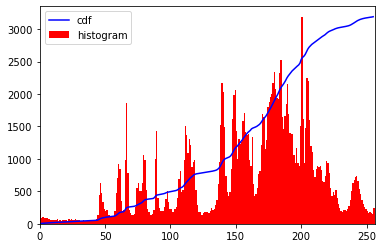

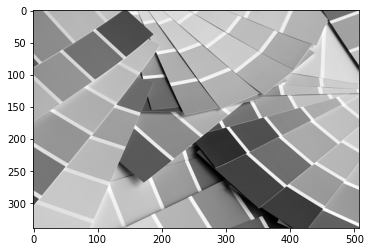

In [49]:
img = cv2.imread('Gray_Scale.jpg',0)

hist,bins = np.histogram(img.flatten(),256,[0,256])      
cdf = hist.cumsum()

cdf_normalized = cdf * hist.max()/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')

plt.show()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

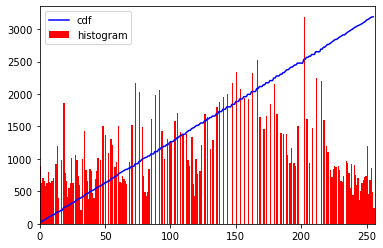

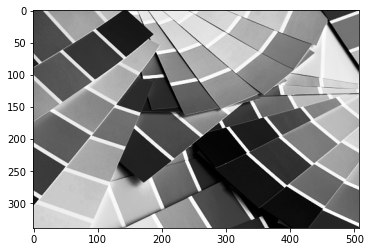

In [50]:
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')

img2 = cdf[img]

hist,bins = np.histogram(img2.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(img2.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')

plt.show()
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))



In [51]:
def Histogram():
    img = cv2.imread('Gray_Scale.jpg',0)

    hist,bins = np.histogram(img.flatten(),256,[0,256])      
    cdf = hist.cumsum()

    cdf_normalized = cdf * hist.max()/ cdf.max()

    plt.plot(cdf_normalized, color = 'b')
    plt.hist(img.flatten(),256,[0,256], color = 'r')
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')

    plt.show()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')

    img2 = cdf[img]

    hist,bins = np.histogram(img2.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()

    plt.plot(cdf_normalized, color = 'b')
    plt.hist(img2.flatten(),256,[0,256], color = 'r')
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')

    plt.show()
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    return img2

## 11- Fourier Transform

In [52]:
def DiscreteFT(photo):
    photo_list=photo.tolist()  #change the image array to list
    M=photo.shape[0]
    N=photo.shape[1]
    RES=photo.copy()
    total=0
    for i in range(M):
        for j in range(N):
            temp=[]
            for x in range(M):
                for y in range(N):
                    ##initial el total =0 in the first loop
                    if(x==0 and y==0):
                        if(photo[x,y].all() == 0 ):
                            total=0
                    else:
                        total = np.exp(-1j*2*math.pi*(((i*x)/M)+((j*y)/N)))
                    temp.append(photo[x,y] * total)
            sum_temp = round(sum(temp))
            res2 = pow(pow(sum_temp.real,2)+pow(sum_temp.imag,2),1/2)
            RES[i,j] = res2
#             print(RES)
    return RES

In [53]:
def Inverse_DiscreteFT(photo):
    photo_list=photo.tolist()  #change the image array to list
    M=photo.shape[0]
    N=photo.shape[1]
    RES=photo.copy()
    total=0
    for i in range(M):
        for j in range(N):
            temp=[]
            for x in range(M):
                for y in range(N):
                    ##initial el total =0 in the first loop
                    if(x==0 and y==0):
                        if(photo[x,y].all() == 0 ):
                            total=0
                    else:
                        total = np.exp(1j*2*math.pi*(((i*x)/M)+((j*y)/N)))
                    temp.append(photo[x,y] * total)
            sum_temp = sum(temp)
            res2 = round((1/M*N)*pow(pow(sum_temp.real,2)+pow(sum_temp.imag,2),1/2))
            RES[i,j] = res2
#             print(RES)
    return RES

## 12- Interpolation

In [54]:
def read_image(path):    
    img = cv2.imread(path)  # cv2.IMREAD_GRAYSCALE)
    size = img.shape
    dimension = (size[0], size[1])
    return img, size, dimension


def image_change_scale(img, dimension, scale=100):
    
    scale /= 100
    new_dimension = (int(dimension[1]*scale), int(dimension[0]*scale))
    resized_img = cv2.resize(img, new_dimension)

    return resized_img


def nearest_interpolation(image, dimension):
    
    new_image = np.zeros((dimension[0], dimension[1], image.shape[2]))

    enlarge_time = int(
        sqrt((dimension[0] * dimension[1]) / (image.shape[0]*image.shape[1])))

    for i in range(dimension[0]):
        for j in range(dimension[1]):
            row = floor(i / enlarge_time)
            column = floor(j / enlarge_time)

            new_image[i, j] = image[row, column]

    return new_image


def bilinear_interpolation(image, dimension):
    
    height = image.shape[0]
    width = image.shape[1]

    scale_x = (width)/(dimension[1])
    scale_y = (height)/(dimension[0])

    new_image = np.zeros((dimension[0], dimension[1], image.shape[2]))

    for k in range(3):
        for i in range(dimension[0]):
            for j in range(dimension[1]):
                x = (j+0.5) * (scale_x) - 0.5
                y = (i+0.5) * (scale_y) - 0.5

                x_int = int(x)
                y_int = int(y)

                # Prevent crossing
                x_int = min(x_int, width-2)
                y_int = min(y_int, height-2)

                x_diff = x - x_int
                y_diff = y - y_int

                a = image[y_int, x_int, k]
                b = image[y_int, x_int+1, k]
                c = image[y_int+1, x_int, k]
                d = image[y_int+1, x_int+1, k]

                pixel = a*(1-x_diff)*(1-y_diff) + b*(x_diff) * \
                    (1-y_diff) + c*(1-x_diff) * (y_diff) + d*x_diff*y_diff

                new_image[i, j, k] = pixel.astype(np.uint8)

    return new_image


def W(x):
    
    a = -0.5
    pos_x = abs(x)
    if -1 <= abs(x) <= 1:
        return ((a+2)*(pos_x**3)) - ((a+3)*(pos_x**2)) + 1
    elif 1 < abs(x) < 2 or -2 < x < -1:
        return ((a * (pos_x**3)) - (5*a*(pos_x**2)) + (8 * a * pos_x) - 4*a)
    else:
        return 0


def bicubic_interpolation(img, dimension):
    
    nrows = dimension[0]
    ncols = dimension[1]

    output = np.zeros((nrows, ncols, img.shape[2]), np.uint8)
    for c in range(img.shape[2]):
        for i in range(nrows):
            for j in range(ncols):
                xm = (i + 0.5) * (img.shape[0]/dimension[0]) - 0.5
                ym = (j + 0.5) * (img.shape[1]/dimension[1]) - 0.5

                xi = floor(xm)
                yi = floor(ym)
                
                u = xm - xi
                v = ym - yi
               
                out = 0
                for n in range(-1, 3):
                    for m in range(-1, 3):
                        if ((xi + n < 0) or (xi + n >= img.shape[1]) or (yi + m < 0) or (yi + m >= img.shape[0])):
                            continue

                        out += (img[xi+n, yi+m, c] * (W(u - n) * W(v - m)))

                output[i, j, c] = np.clip(out, 0, 255)

    return output

## 13- Gray Scale Filter

In [55]:
def GreyScaleFilter(photo):    
    array1 = np.zeros((photo.shape[0],photo.shape[1])) #array for el grey 
    #to obtain the grey scale we should multiple in few factors
    array1[ : , : ] = (0.2126*photo[:,:,2] + 0.7152*photo[:,:,1] + 0.0722*photo[:,:,0]).astype(np.uint8)
    return array1